# Bootstrapping

_Author: Christoph Rahmede_

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-data" data-toc-modified-id="The-data-1">The data</a></span></li><li><span><a href="#The-bootstrap" data-toc-modified-id="The-bootstrap-2">The bootstrap</a></span><ul class="toc-item"><li><span><a href="#Bootstrap-confidence-interval-for-the-mean" data-toc-modified-id="Bootstrap-confidence-interval-for-the-mean-2.1">Bootstrap confidence interval for the mean</a></span></li><li><span><a href="#Classical-confidence-interval-for-the-mean" data-toc-modified-id="Classical-confidence-interval-for-the-mean-2.2">Classical confidence interval for the mean</a></span></li><li><span><a href="#Bootstrap-interval-for-the-median" data-toc-modified-id="Bootstrap-interval-for-the-median-2.3">Bootstrap interval for the median</a></span></li><li><span><a href="#Bootstrap-interval-for-the-standard-deviation" data-toc-modified-id="Bootstrap-interval-for-the-standard-deviation-2.4">Bootstrap interval for the standard deviation</a></span></li></ul></li><li><span><a href="#Bootstrapping-with-ARCH" data-toc-modified-id="Bootstrapping-with-ARCH-3">Bootstrapping with ARCH</a></span><ul class="toc-item"><li><span><a href="#Correlation" data-toc-modified-id="Correlation-3.1">Correlation</a></span></li><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-3.2">Linear Regression</a></span><ul class="toc-item"><li><span><a href="#Statsmodels" data-toc-modified-id="Statsmodels-3.2.1">Statsmodels</a></span></li><li><span><a href="#Linear-regression-with-the-nonparametric-bootstrap" data-toc-modified-id="Linear-regression-with-the-nonparametric-bootstrap-3.2.2">Linear regression with the nonparametric bootstrap</a></span></li></ul></li><li><span><a href="#Write-a-new-wrapper-which-allows-to-determine-confidence-intervals-when-using-the-Lasso" data-toc-modified-id="Write-a-new-wrapper-which-allows-to-determine-confidence-intervals-when-using-the-Lasso-3.3">Write a new wrapper which allows to determine confidence intervals when using the Lasso</a></span></li><li><span><a href="#Write-a-new-wrapper-which-allows-to-use-Logistic-Regression" data-toc-modified-id="Write-a-new-wrapper-which-allows-to-use-Logistic-Regression-3.4">Write a new wrapper which allows to use Logistic Regression</a></span></li></ul></li></ul></div>

Bootstrapping gives us another way of obtaining confidence intervals. The idea of the most basic type, the non-parametric bootstrap that we will use here, is quite simple. We sample from the observed data distribution repeatedly with replacement. In each iteration, we draw the same number of samples, determine the desired statistic, e.g. the mean, from them and obtain in this way the distribution of our statistic. In the end we simply have to order the sample statistics and to obtain the percentile boundaries appropriate for the desired confidence level.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

In [2]:
from scipy import stats

## The data

Our dataset contains a lot of variables. We would like to obtain confidence intervals for statistics involving one or more of these variables.

In [3]:
df = pd.read_csv(
    '../../../dataset-collection/Bike-Sharing-Dataset/hour.csv')
df.drop(['instant','dteday'],axis=1,inplace=True)
df.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


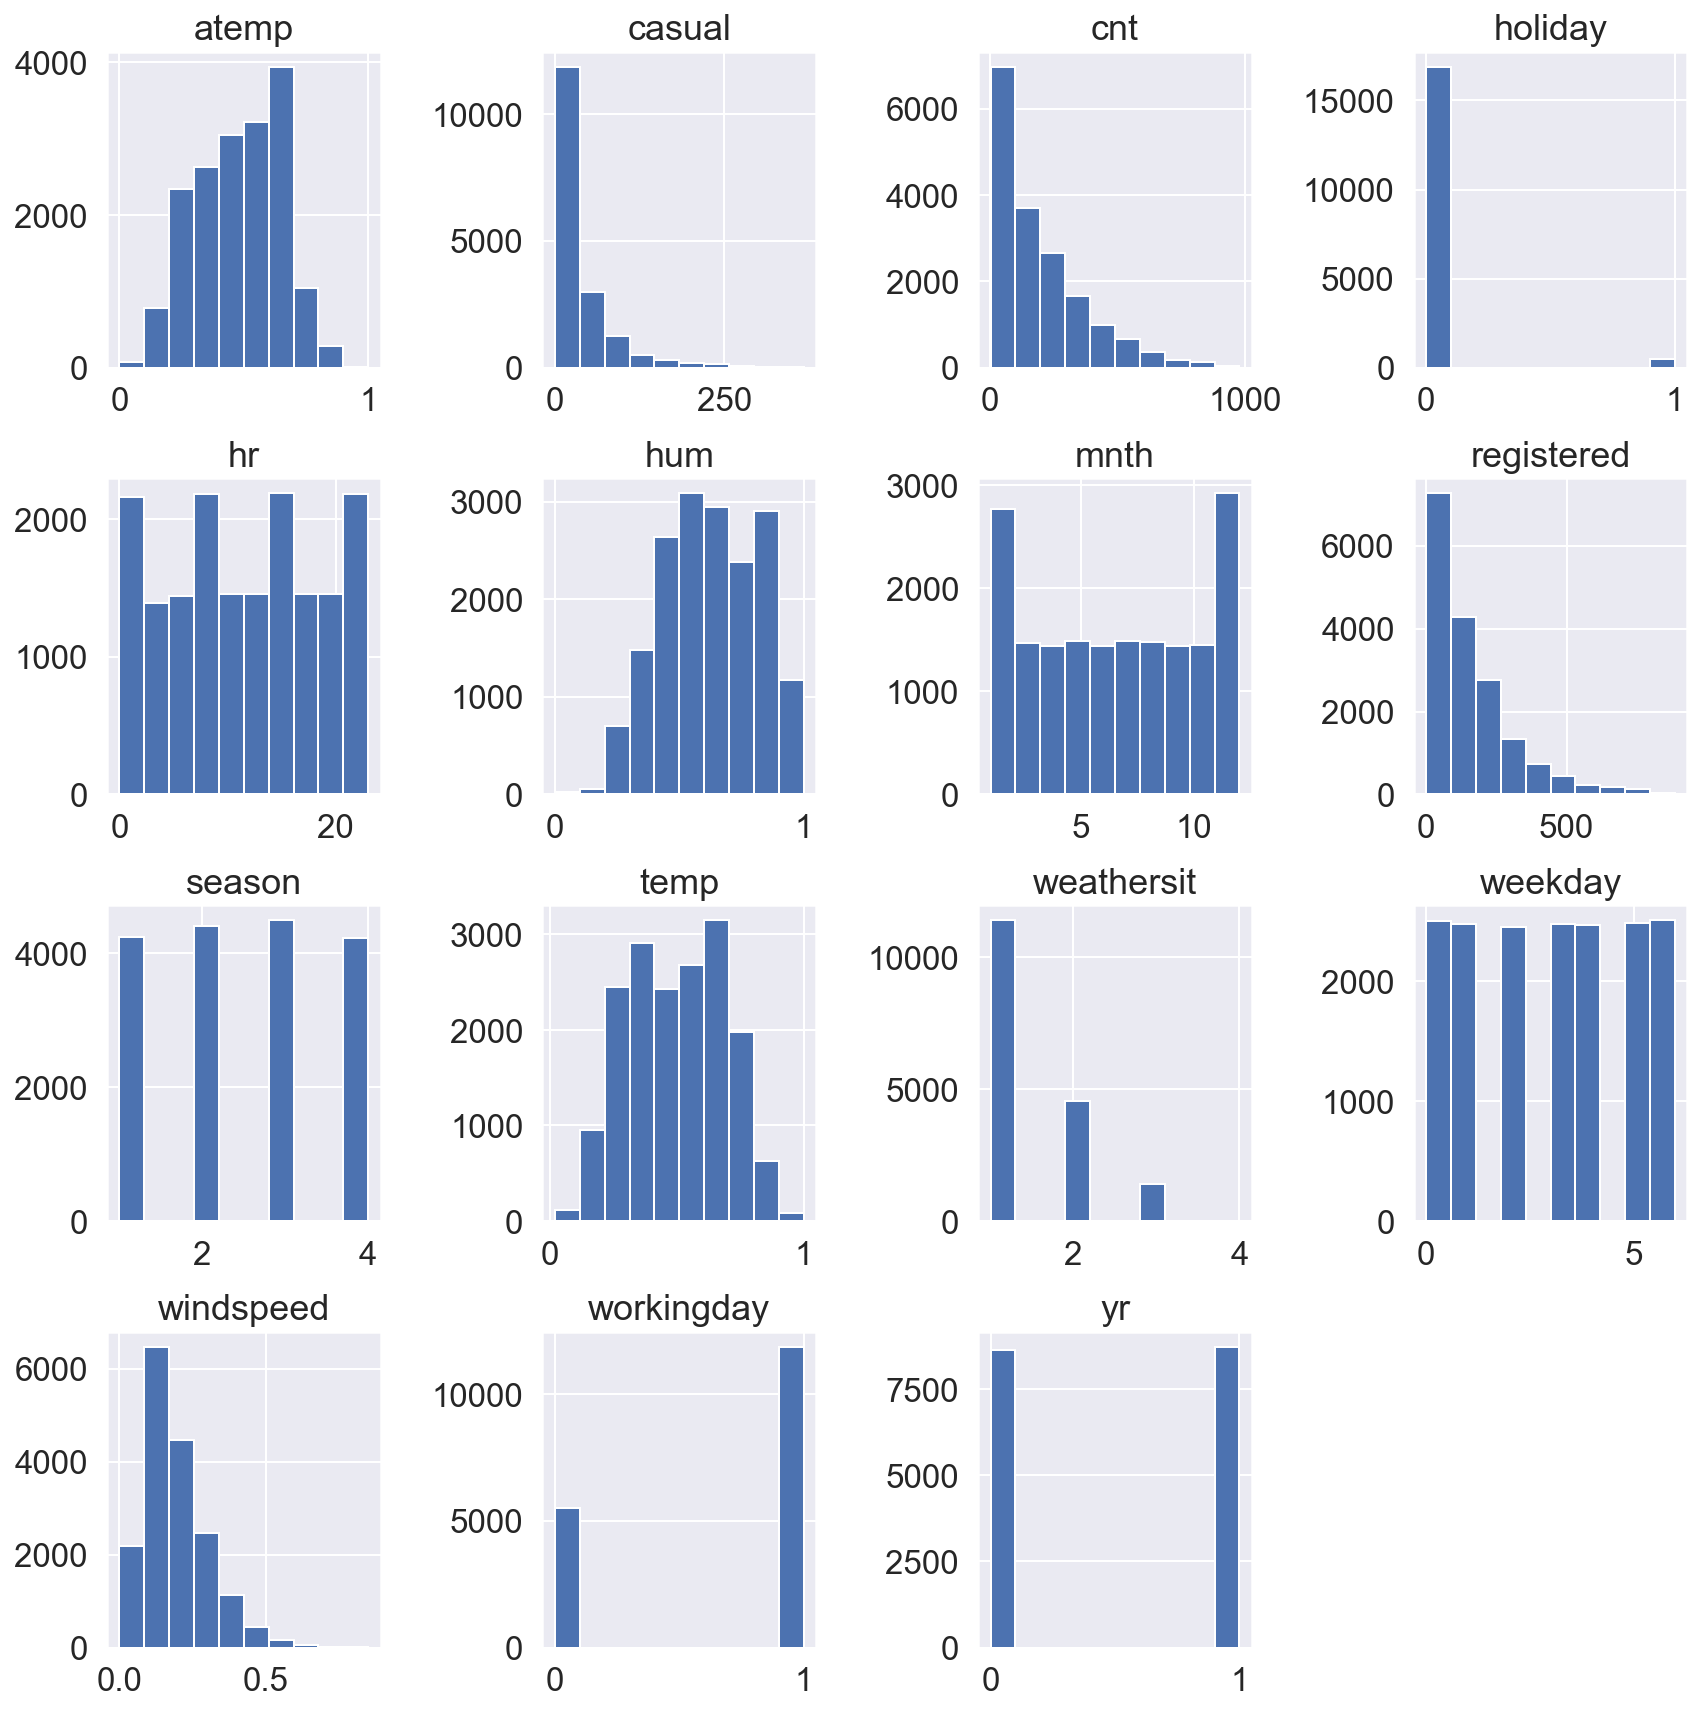

In [4]:
fig, ax = plt.subplots(figsize=(12,12))
df.hist(ax=ax)
fig.tight_layout()
plt.show()

## The bootstrap

We write two functions. One is for performing the sampling, the other one is for obtaining the percentile boundaries from all the samples.

In [5]:
def bootstrap(df,func,iterations=1000,sample_size = 1000):
    estimates = np.array([func(df.sample(sample_size,replace=True)) for i in range(iterations)])
    return estimates

def percentile_scores(estimates, level=95):
    return stats.scoreatpercentile(estimates,(100-level)/2), stats.scoreatpercentile(estimates,level+(100-level)/2)

In [6]:
estimates = bootstrap(df.temp,np.mean,sample_size=len(df))

### Bootstrap confidence interval for the mean

In [7]:
percentile_scores(estimates)

(0.4940645894470336, 0.4998309166235139)

### Classical confidence interval for the mean

In [8]:
df.temp.mean()+df.temp.std()/len(df)**0.5*np.array(stats.norm().interval(0.95))

array([0.49412436, 0.49984998])

### Bootstrap interval for the median

In [9]:
estimates = bootstrap(df.temp,np.median,sample_size=len(df))
percentile_scores(estimates)

(0.5, 0.5)

### Bootstrap interval for the standard deviation

In [10]:
estimates = bootstrap(df.temp,np.std,sample_size=len(df))
percentile_scores(estimates)

(0.19118015306309877, 0.193961205343818)

## Bootstrapping with ARCH

The ARCH package offers nice functionality for bootstrapping. We can implement the non-parametric bootstrap with the percentile method as used above. Additionally, there are many varieties which can be specified through the type of bootstrap and the method for deriving confidence intervals from the samples.

In [11]:
from arch.bootstrap import IIDBootstrap

First we tell which bootstrap instance we would like to use. We choose the one appropriate for independent identically distributed data.

In [12]:
bs = IIDBootstrap(df.temp)

Then we can determine the confidence intervals specifying the statistic, number of bootstrap iterations and the method for determining the confidence intervals. We fix the required confidence level with `size`.

In [13]:
ci = bs.conf_int(np.mean, 1000, size=0.95, method='percentile')
ci

array([[0.49413404],
       [0.49984352]])

Exchanging the statistic is straight-forward

In [14]:
ci = bs.conf_int(np.median, 1000, method='percentile')
ci

array([[0.5],
       [0.5]])

In [15]:
ci = bs.conf_int(np.std, 1000, method='percentile')
ci

array([[0.19112728],
       [0.19407707]])

We now demonstrate how to obtain confidence intervals for correlations between the variables and the regression coefficients of the auto-mpg dataset.

In [16]:
df = pd.read_csv(
    '../../../dataset-collection/auto-mpg/auto-mpg.csv', sep='\s+', header=None)
df.columns = ['mpg', 'cylinders', 'displacement', 'horsepower',
              'weight', 'acceleration', 'year', 'origin', 'name']
df.drop(df[df.horsepower == '?'].index, inplace=True)
df['horsepower'] = df.horsepower.astype(float)
df['brand'] = df.name.map(lambda x: x.split(' ')[0]
                          ).replace(
    {'toyouta': 'toyota',
     'maxda': 'mazda',
     'chevroelt': 'chevrolet',
     'vw': 'volkswagen',
     'vokswagen': 'volkswagen',
     'mercedes-benz': 'mercedes'})
# this time we reset the index - this is important
df.reset_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 11 columns):
index           392 non-null int64
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null float64
weight          392 non-null float64
acceleration    392 non-null float64
year            392 non-null int64
origin          392 non-null int64
name            392 non-null object
brand           392 non-null object
dtypes: float64(5), int64(4), object(2)
memory usage: 33.8+ KB


### Correlation

In [17]:
df[['horsepower','mpg']].corr().iloc[0,1]

-0.7784267838977751

Now we will need a wrapper which calculates internally the quantities that we want to know during each bootstrap iteration.

In [18]:
def corr_wrap(endog):
    return endog.corr().iloc[0,1]

The function should work on its own:

In [19]:
corr_wrap(df[['horsepower','mpg']])

-0.7784267838977751

Now the bootstrap:

In [20]:
bs = IIDBootstrap(endog=df[['horsepower','mpg']])

In [21]:
ci = bs.conf_int(corr_wrap, 1000, method='percentile')
ci

array([[-0.80663177],
       [-0.74932607]])

### Linear Regression

Let's now have a look at linear regression. 

#### Statsmodels

In statsmodels we got the following confidence intervals:

In [22]:
import statsmodels.api as sm

In [23]:
results = sm.OLS(df.mpg, sm.add_constant(df[['horsepower']])).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Sun, 10 Feb 2019   Prob (F-statistic):           7.03e-81
Time:                        20:44:22   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.9359      0.717     55.660      0.000      38.525      41.347
horsepower    -0.1578      0.006    -24.489      0.000      -0.171      -0.145
==============================================================================
Omnibus:                       16.432   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.305
Skew:                           0.492   Prob(JB):                     0.000175
Kurtosis:                       3.299   Cond. No.                         322.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Linear regression with the nonparametric bootstrap

There are various ways how one could proceed. The straight-forward one is to simply fit a linear regression model during each bootstrap iteration step and return the coefficients. We can also obtain the scores at each iteration.

In [24]:
from sklearn.linear_model import LinearRegression
def linreg_wrap(endog, exog):
    model = LinearRegression()
    model.fit(exog, endog)

    return np.array([model.intercept_]+list(model.coef_.ravel())+[model.score(exog,endog)])

In [25]:
bs = IIDBootstrap(endog=df['mpg'], exog=df[['horsepower']])
bs.seed(10)

In [26]:
linreg_wrap(df['mpg'], df[['horsepower']])

array([39.93586102, -0.15784473,  0.60594826])

In [27]:
ci = bs.conf_int(linreg_wrap, 1000, method='percentile')

In [28]:
ci = pd.DataFrame(ci, index=['Lower','Upper'])
ci

,0,1,2
Lower,38.383555,-0.172834,0.561062
Upper,41.579555,-0.145327,0.653684


### Write a new wrapper which allows to determine confidence intervals when using the Lasso

In [29]:
from sklearn.linear_model import Lasso

### Write a new wrapper which allows to use Logistic Regression

- Predict `origin` as the outcome variable. 
- You will have to use binary logistic regression to compare to statsmodels' `sm.Logit` (e.g. by setting `df['origin']==1`).
- If you want to make your wrapper work for multiple classes, you will have to flatten the array of coefficients.

In [30]:
from sklearn.linear_model import LogisticRegression